In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

In [65]:
def split_data(stock, lookback):
    data_raw = stock# convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback+1])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
    
    
def train_mse(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = LSTM(input_dim, hidden_dim,  n_layers,output_dim)
    
    # Defining loss function and optimizer
    criterion1 = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    mseloss_train = []
    mseloss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h,c = model.init_hidden(batch_size)
        avg_loss1 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            #c = c.data
            model.zero_grad()
            
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float())
            loss1.backward()
           
            optimizer.step()
            avg_loss1 += loss1.item()
        
        avg_loss1 /= length
        mseloss_train.append(avg_loss1)
        print("Epoch {}/{} Done, Total Training MSELoss: {}".format(epoch, EPOCHS, avg_loss1))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        
        loss1 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss1 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion1(out, label.float()).item()
            avg_loss1 += testloss
            
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        mseloss_test.append(avg_loss1)    
        print("Total Testing MSELoss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, mseloss_train, mseloss_test, predictions, values

def train_l1(train_loader, test_loader, learn_rate, hidden_dim=64, EPOCHS=20, model_type="GRU"):
    
    # Setting common hyperparameters
    input_dim = 1
    output_dim = 1
    n_layers = 1
    # Instantiating the models
    model = LSTM(input_dim, hidden_dim, output_dim, n_layers)
    
    # Defining loss function and optimizer
    criterion2 = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    model.train()
    print("Starting Training of {} model".format(model_type))
    epoch_times = []
    l1loss_train = []
    l1loss_test = []
    # Start training loop
    for epoch in range(1,EPOCHS+1):
    
        start_time = time.perf_counter()
        #h = model.init_hidden(batch_size)
        avg_loss2 = 0.
        for x, label in train_loader:
            length = len(train_loader)
            #h = h.data
            model.zero_grad()

            out = model.forward(x.float())
            
            loss2 = criterion2(out, label.float())
            loss2.backward()
            optimizer.step()
            avg_loss2 += loss2.item()
        
        avg_loss2 /= length
        l1loss_train.append(avg_loss2)
        print("Epoch {}/{} Done, Total Training L1Loss: {}".format(epoch, EPOCHS, avg_loss2))
        
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion2 = nn.L1Loss()
        
        loss2 = []
        for x, label in test_loader:
            length = len(test_loader)
            avg_loss2 = 0.
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            testloss = criterion2(out, label.float()).item()
            avg_loss2 += testloss
            predictions.append(out.detach().numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
        
        l1loss_test.append(avg_loss2)
        print("Total Testing L1Loss: {}".format(testloss))
       
        current_time = time.perf_counter()
        epoch_times.append(current_time-start_time)
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
        print()
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, l1loss_train, l1loss_test, predictions, values

def evaluate(model, test_loader):
    with torch.no_grad():
        predictions = []
        values = []
        #h = model.init_hidden(1)
        criterion1 = nn.MSELoss()
        criterion2 = nn.L1Loss()
        
        loss1 = 0
        loss2 = 0
        for x, label in test_loader:
            #h = h.data
            model.zero_grad()
    
            out = model.forward(x.float())
            loss1 = criterion1(out, label.float()).item()
            loss2 = criterion2(out, label.float()).item()
            predictions.append(out.numpy().reshape(-1))
            values.append(label.numpy().reshape(-1))
            
        print("Total MSELoss: {}".format(loss1))
        print("Total L1Loss: {}".format(loss2))
        
            
    return predictions, values, loss1,loss2

In [70]:
sp500_df = pd.read_csv("sp500.csv")
sp500_df['Date'] = pd.to_datetime(sp500_df['Date'])
sp500_df.set_index('Date',inplace=True)
sp500_df = pd.DataFrame(sp500_df['SP500'])
sp500_df.dropna(inplace=True)
sp500_df

,SP500
Date,
1871-01-01,4.44
1871-02-01,4.50
1871-03-01,4.61
1871-04-01,4.74
1871-05-01,4.86
...,...
2017-12-01,2664.34
2018-01-01,2789.80
2018-02-01,2705.16


In [71]:
# Scaling the input data
sc = MinMaxScaler()
#label_sc = MinMaxScaler()
scaled_sp = sc.fit_transform(sp500_df.values)
# Obtaining the Scale for the labels(usage data) so that output can be re-scaled to actual value during evaluation
#label_sc.fit(microsoft_df.iloc[:,0].values.reshape(-1,1))
lookback = 5
train_x,train_y,test_x,test_y = split_data(scaled_sp, lookback)

# Print data shape
print('X_train.shape: ', train_x.shape)
print('y_train.shape: ', train_y.shape)
print('X_test.shape: ', test_x.shape) 
print('y_test.shape: ', test_y.shape)

X_train.shape:  (1410, 5, 1)
y_train.shape:  (1410, 1)
X_test.shape:  (353, 5, 1)
y_test.shape:  (353, 1)


In [72]:
batch_size = 32
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=False, batch_size=1, drop_last=True)

In [73]:
lr = 0.001
gru_model5, mseloss_train, mseloss_test,predictions, values = train_mse(train_loader, test_loader,lr,EPOCHS=50, model_type="LSTM")
gru_model5, l1loss_train, l1loss_test,predictions, values = train_l1(train_loader, test_loader,lr,EPOCHS=50, model_type="LSTM")

Starting Training of LSTM model
Epoch 1/50 Done, Total Training MSELoss: 0.00021194988205893011
Total Testing MSELoss: 0.673011064529419
Total Time Elapsed: 0.5975203389998569 seconds

Epoch 2/50 Done, Total Training MSELoss: 0.0006025496316129617
Total Testing MSELoss: 0.6785908937454224
Total Time Elapsed: 0.5456834019996677 seconds

Epoch 3/50 Done, Total Training MSELoss: 0.00043372724338491315
Total Testing MSELoss: 0.6383035182952881
Total Time Elapsed: 0.5354150020002635 seconds

Epoch 4/50 Done, Total Training MSELoss: 0.0004343922868072654
Total Testing MSELoss: 0.6271106600761414
Total Time Elapsed: 0.5590572759992938 seconds

Epoch 5/50 Done, Total Training MSELoss: 0.0004475526704407106
Total Testing MSELoss: 0.6101619601249695
Total Time Elapsed: 0.5825297849996787 seconds

Epoch 6/50 Done, Total Training MSELoss: 0.0004846325569913419
Total Testing MSELoss: 0.5987440347671509
Total Time Elapsed: 0.7318523599997206 seconds

Epoch 7/50 Done, Total Training MSELoss: 0.000520

Total Testing L1Loss: 0.8333883881568909
Total Time Elapsed: 0.5007504989998779 seconds

Epoch 4/50 Done, Total Training L1Loss: 0.023243662440853022
Total Testing L1Loss: 0.8263235688209534
Total Time Elapsed: 0.5016728900000089 seconds

Epoch 5/50 Done, Total Training L1Loss: 0.021758111143505877
Total Testing L1Loss: 0.8170701861381531
Total Time Elapsed: 0.5016971149998426 seconds

Epoch 6/50 Done, Total Training L1Loss: 0.024985718315954066
Total Testing L1Loss: 0.8190217018127441
Total Time Elapsed: 0.513146364000022 seconds

Epoch 7/50 Done, Total Training L1Loss: 0.02638318643122065
Total Testing L1Loss: 0.8183722496032715
Total Time Elapsed: 0.49964600699968287 seconds

Epoch 8/50 Done, Total Training L1Loss: 0.018048463807314296
Total Testing L1Loss: 0.8039429187774658
Total Time Elapsed: 0.5017011840000123 seconds

Epoch 9/50 Done, Total Training L1Loss: 0.027042756531789728
Total Testing L1Loss: 0.8117040395736694
Total Time Elapsed: 0.5612563450004018 seconds

Epoch 10/50 

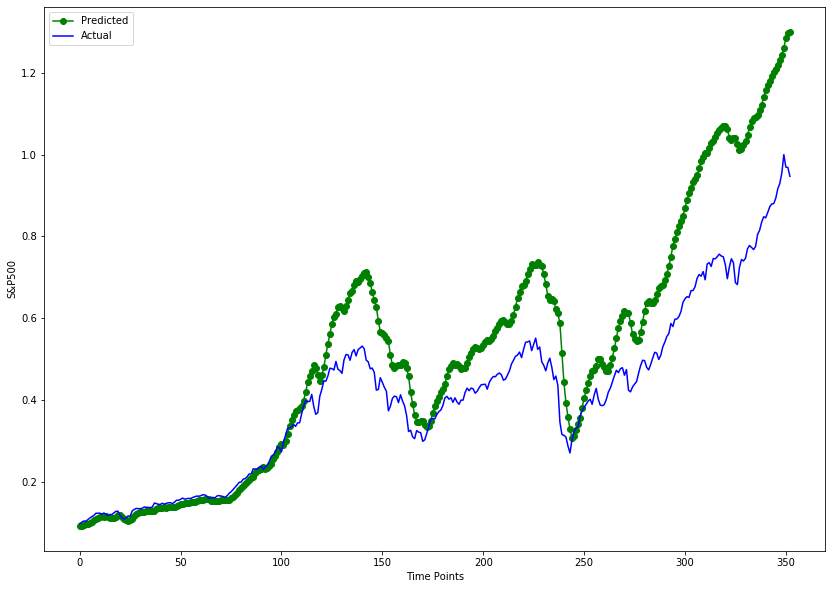

In [74]:
plt.figure(figsize=(14,10))
plt.plot(np.asarray(predictions).reshape(-1,1), "-o", color="g", label="Predicted")
plt.plot(np.asarray(values).reshape(-1,1), color="b", label="Actual")
plt.ylabel('S&P500')
plt.xlabel('Time Points')
plt.legend()

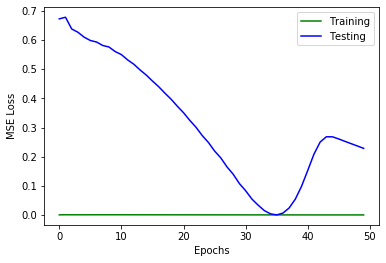

In [75]:
plt.plot(mseloss_train, color="g", label="Training")
plt.plot(mseloss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()

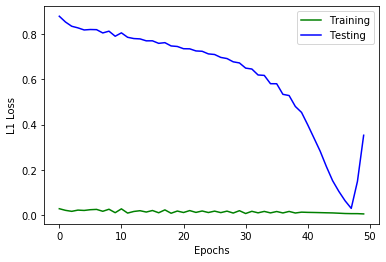

In [76]:
plt.plot(l1loss_train, color="g", label="Training")
plt.plot(l1loss_test, color="b", label="Testing")
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.legend()